*(to use GPU in colab go to Runtime -> Change Runtime Type and change the hardware accelerator)*

Только вчера закончился долгожданный посвят, но времени на отдых нет — до дедлайна по Variational Autoencoders всего 4 часа! Вы открываете ноутбук, готовясь внести последние штрихи, но с ужасом понимаете: задание в хаосе. Часть кода исчезла, а оставшиеся строки пестрят ошибками. В каком же состоянии Вы были, когда работали над этим вчера? Время неумолимо бежит, и теперь нужно срочно все исправить и успеть обучить модели.

In [16]:
# some prelimenaries
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import numpy as np
import matplotlib.pylab as plt

torch.set_num_threads(16)
torch.manual_seed(0)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

print("Using torch version {}".format(torch.__version__))
print("Using {} device".format(device))

Using torch version 2.1.1
Using cuda:0 device


Эти составители задания явно не желали облегчить Вам жизнь! Подсунули сломанный MNIST, нужно возиться с размерностью. И как будто этого недостаточно, ведь для восстановления её нельзя пользоваться любыми вспомогательными функциями из PyTorch и NumPy!

In [17]:
def transpose_from_scratch(lst):
    """
    Меняет местами две оси (размерности) вложенного списка и возвращает результат в виде torch.Tensor.

    Parameters:
    lst: Входной многомерный вложенный список или torch.Tensor
    Returns:
    torch.Tensor: Новый тензор с переставленными осями
    """
    if isinstance(lst, torch.Tensor):
        lst = lst.tolist()
    n = len(lst)
    m = len(lst[0])
    return torch.tensor([[lst[i][j] for i in range(n)] for j in range(m)])

In [18]:
def transpose_from_scratch(lst):
    """
    Меняет местами две оси (размерности) вложенного списка и возвращает результат в виде torch.Tensor.

    Parameters:
    lst: Входной многомерный вложенный список или torch.Tensor
    Returns:
    torch.Tensor: Новый тензор с переставленными осями
    """
    if isinstance(lst, torch.Tensor):
        lst = lst.tolist()
    n = len(lst)
    m = len(lst[0])
    transposed_lst = torch.stack([torch.tensor([lst[i][j] for i in range(n)]) for j in range(m)])
    return torch.tensor(transposed_lst)

In [19]:
def transpose_from_scratch(lst):
    """
    Меняет местами две оси (размерности) вложенного списка и возвращает результат в виде torch.Tensor.

    Parameters:
    lst: Входной многомерный вложенный список или torch.Tensor
    Returns:
    torch.Tensor: Новый тензор с переставленными осями
    """
    if isinstance(lst, torch.Tensor):
        lst = lst.tolist()
    n = len(lst)
    m = len(lst[0])
    transposed_lst = torch.stack([torch.tensor([lst[i][j] for i in range(n)]) for j in range(m)])
    return torch.tensor(transposed_lst)

In [20]:
lst = [[1, 2, 3], [4, 5, 6]]

transpose_from_scratch(lst)

/tmp/ipykernel_1607341/104530376.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(transposed_lst)


tensor([[1, 4],
        [2, 5],
        [3, 6]])

Фух, ну и пришлось повозиться. Теперь осталось только настроить загрузчики тренировочных и тестовых данных.

In [21]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

In [22]:
train_data = torch.load("transposed_mnist_train.pt", map_location=device)
train_data = [(transpose_from_scratch(data), label) for data, label in train_data]

# Create a DataLoader for the test data
train_loader = DataLoader(
    CustomDataset(train_data),
    batch_size=32,
    shuffle=False,
)

/tmp/ipykernel_1607341/104530376.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(transposed_lst)


In [23]:
# Load and transpose the test data
test_data = torch.load("transposed_mnist_test.pt", map_location=device)
# test_data = [(transpose_from_scratch(data), label) for data, label in test_data]

# Create a DataLoader for the test data
test_loader = DataLoader(
    CustomDataset(test_data),
    batch_size=32,
    shuffle=False,
)

# Вариационные автоэнкодеры

Ну вот, Вы наконец добрались до самой важной части. Теперь нужно разобраться с реализацией VAE на MNIST и поправить все косяки, которые Вы наделали вчера, чтобы обучение прошло нормально и тестовый loss был в порядке.

# Распределения для вариационных автоэнкодеров

Воспоминания со вчерашнего дня возвращаются медленно, поэтому освежим необходимые для выполнения задания основы. Вам понадобятся два типа распределений для вероятностной модели:
- **Для z**: используйте вектор независимых [нормально распределённых](https://pytorch.org/docs/stable/distributions.html#normal)  величин.
- **Для x**: используйте вектор независимых случайных величин с распределением [Бернулли](https://pytorch.org/docs/stable/distributions.html#bernoulli).

По умолчанию, соответствующие классы в PyTorch моделируют тензор независимых случайных величин. Чтобы представить матрицу таких величин как батч случайных векторов, можно использовать класс [Independent](https://pytorch.org/docs/stable/distributions.html#independent).

### Распределение Бернулли

Лучше инициализировать класс Бернулли **логитами**, а не вероятностями. Это помогает избежать нестабильности при вычислении логарифма вероятности.

В этом задании Вам будет нужно использовать этот класс для моделирования $p(x \mid z)$, параметризованного выходом декодера. Для вычисления функции потерь вам нужно будет использовать метод *log_prob()* для вычисления $\log p(x \mid z)$ на входных изображениях.

### Нормальное распределение

Вы будете использовать этот класс для определения распределения $q(z \mid x)$ и распределения скрытой переменной $p(z)$.
- Для функции потерь используйте метод *log_prob()*.
- Чтобы сгенерировать выборку из $q(z \mid x)$, которую затем можно передать в декодер, используйте метод сэмплирования, реализующий трюк репараметризации. При этом выборка вычисляется как $z = \mu(x) + \varepsilon \odot \sigma(x)$, где $\varepsilon$ — стандартный гауссов шум.

Здесь $\odot$ обозначает поэлементное умножение.

Следует отметить, что метод сэмплирования (rsample), реализующий [трюк репараметризации](https://runebook.dev/en/articles/pytorch/distributions/torch.distributions.half_normal.HalfNormal.has_rsample), отличается от стандартного метода выборки и специально предназначен для корректного учета градиентов, что особенно важно при обучении моделей, таких как вариационные автоэнкодеры.

In [24]:
from torch.distributions import Normal, Bernoulli, Independent, constraints

Bernoulli.support = constraints.interval(0, 1)

# Вариационные автоэнкодеры

Вариационный автоэнкодер состоит из двух основных компонентов. Первая компонента - вероятностная модель для наблюдений:
\begin{align}
& p(x, z \mid \theta) =  p(z) p(x \mid z, \theta) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid z, \theta) = \prod_{i = 1}^D p_i(z, \theta)^{x_i} (1 - p_i(z, \theta))^{1 - x_i}.
\end{align}

Здесь $p(z)$ - нормальное распределение со средним $0$ и единичной ковариацией, а $p(x \mid z, \theta)$ моделируется как произведение распределений Бернулли для каждого элемента данных.

Вторая компонента - вариационное приближение, которое используется для вычисления нижней границы на маргинальное правдоподобие (вариационные автоэнкодеры используют отрицательную нижнюю границу в качестве функции потерь)
\begin{equation}
q(z \mid x, \phi) = \mathcal N(z \mid \mu(x, \phi), \operatorname{diag}(\sigma^2(x, \phi))).
\end{equation}

Нижняя граница для вероятности наблюдения $x$ из мини-батча выражается как:
$$ \mathcal L(x, \theta, \phi) = \mathbb E_{q(z \mid x, \phi)} \left[ \log p(x \mid z, \phi) + \log p(z) - \log q(z \mid x, \theta) \right] $$

Однако вычислить это математическое ожидания напрямую сложно. Стандартный подход - аппроксимировать его с помощью оценки Монте-Карло с одним сэмплом:
\begin{align*}
\log p(x \mid z_0, \phi) + \log p(z_0) - \log q(z_0 \mid x, \theta) \\
z_0 = \mu(x, \phi) + \sigma^2(x, \phi)^T \varepsilon_0 \\
\varepsilon_0 \sim \mathcal N(0, I)
\end{align*}

Для обучения модели мы усредняем значения нижней границы по мини-батчу и затем максимизируем это среднее с помощью градиентного подъема:
$$ \frac{1}{N} \sum_{n=1}^N \log p(x_n \mid z_n, \phi) + \log p(z_n) - \log q(z_n \mid x_n, \theta) \rightarrow \max_{\theta, \phi} $$

## Энкодер и декодер

Распределение $q(z\mid x, \theta)$ называется **энкодером**, так как оно кодирует данные $x$ в латентное представление $z$. Распределение $p(x\mid z, \phi)$ называется **декодером**, поскольку оно декодирует латентное представление обратно в данные $x$.

Для параметризации этих распределений используются для нейронные сети:
- **enc** принимает на вход $x$ и возвращает вектор размерности $2\times d$, который задаёт среднее $\mu(x, \phi)$ и стандартное отклонение $\sigma(x, \phi)$ для распределения $q(z\mid x,\theta)$.
- **dec** принимает на вход латентное представление $z$ и возвращает логиты для распределения $p(x\mid z,\phi)$.

Структура вычислительного графа вариационного автоэнкодера похожа на обычный автоэнкодер, но с добавлением стохастической переменной $\varepsilon$:

![vae](https://github.com/Berdash/CV_notebook/blob/main/vae.png?raw=true)

К сожалению, даже если архитектура когда была в задании, вы ее успели удалить, чтобы написать свою.

**Ожидается**, что:
Вы не будете менять размерности на входе, выходе и на скрытом слое, а также будете в своей реализации четко следовать тексту ниже

**Энкодер** будет принимать на вход изображение, развернутое в вектор длины D = 28 * 28, и преобразовывать его в латентное представление.
Архитектура должна включать всего три линейных слоя (один входной, один выходной и один скрытый), nn.Linear и две функции активации nn.ReLU.
Последний слой должен возвращать вектор размерности 2 * d, где d — размерность латентного пространства. Этот вектор будет использоваться для вычисления среднего и стандартного отклонения в репараметризации.

**Декодер** будет принимать на вход латентное представление размерности d и восстанавливать его в изображение размерности D.
Декодер должен опять же включать всего три линейных слоя (один входной, один выходной и один скрытый), nn.Linear и две функции активации nn.ReLU.
Последний слой должен возвращать вектор размерности D.

In [25]:
d, nh, D = 32, 200, 28 * 28

enc = nn.Sequential(
    nn.Linear(D, nh),
    nn.ReLU(),
    nn.Linear(nh, nh),
    nn.ReLU(),
    nn.Linear(nh, 2 * d),
)

dec = nn.Sequential(
    nn.Linear(d, nh),
    nn.ReLU(),
    nn.Linear(nh, nh),
    nn.ReLU(),
    nn.Linear(nh, D),
    # nn.Sigmoid(),
)

## Функция потерь вариационного автоэнкодера

Вот мы и добрались до того самого места, где ваши руки вчера особенно порезвились! Здесь явно спрятались три ошибки — сумеете их отыскать? Подсказка: теория может стать вашим лучшим другом в этом поиске!

In [26]:
def loss_vae(x, encoder, decoder):
    """
    returns
    1. the avergave value of negative ELBO across the minibatch x
    2. and the output of the decoder
    """
    batch_size = x.size(0)
    encoder_output = encoder(x)
    pz = Independent(
        Normal(
            loc=torch.zeros(batch_size, d).to(device),
            scale=torch.ones(batch_size, d).to(device),
        ),
        reinterpreted_batch_ndims=1,
    )
    qz_x = Independent(
        Normal(
            loc=encoder_output[:, :d],
            # scale=torch.exp(encoder_output[:, :d]),
            scale=torch.exp(0.5 * encoder_output[:, d:]),
        ),
        reinterpreted_batch_ndims=1,
    )
    z = qz_x.sample()

    decoder_output = decoder(z)
    px_z = Independent(Bernoulli(logits=decoder_output), reinterpreted_batch_ndims=1)

    loss = -(px_z.log_prob(x) + pz.log_prob(z) - qz_x.log_prob(z)).mean()
    return loss, decoder_output

In [12]:
from torch.distributions import kl_divergence


def loss_vae(x, encoder, decoder):
    """
    Computes the VAE loss, including the negative ELBO.

    Args:
        x: Input data (binary values expected for Bernoulli likelihood).
        encoder: Encoder network, outputting 2*d latent parameters (mean and log-variance).
        decoder: Decoder network, outputting logits for Bernoulli likelihood.
        d: Latent space dimensionality.
        device: Torch device (e.g., "cuda" or "cpu").

    Returns:
        loss: The average negative ELBO across the minibatch.
        decoder_output: The logits output by the decoder.
    """
    batch_size = x.size(0)
    x = x.to(device)  # Ensure x is on the correct device

    # Encode x to latent parameters (mean and log-variance)
    encoder_output = encoder(x)
    mu, log_var = encoder_output[:, :d], encoder_output[:, d:]  # Mean and log-variance

    # Variational posterior q(z|x)
    scale = torch.exp(0.5 * log_var)  # Stability
    qz_x = Independent(Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1)

    # Sample latent variable z
    z = qz_x.rsample()

    # Prior p(z) = N(0, I)
    pz = Independent(
        Normal(loc=torch.zeros(d).to(device), scale=torch.ones(d).to(device)),
        reinterpreted_batch_ndims=1,
    )

    # Decode z to logits for Bernoulli likelihood
    decoder_output = decoder(z)
    px_z = Independent(Bernoulli(logits=decoder_output), reinterpreted_batch_ndims=1)

    # Reconstruction loss: log p(x|z)
    reconstruction_loss = px_z.log_prob(x).mean()

    # KL divergence: KL[q(z|x) || p(z)]
    kl_div = kl_divergence(qz_x, pz).mean()

    # Negative ELBO
    loss = -(reconstruction_loss - kl_div)

    return loss, decoder_output

In [14]:
import torch
from torch.distributions import kl_divergence, Independent, Normal, Bernoulli


device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


def loss_vae(x, encoder, decoder):
    """
    returns
    1. the avergave value of negative ELBO across the minibatch x
    2. and the output of the decoder
    """
    batch_size = x.size(0)
    # x = x.to(device)  # Ensure x is on the correct device

    # Encode x to latent parameters (mean and log-variance)
    encoder_output = encoder(x)
    mu, log_var = encoder_output[:, :d], encoder_output[:, d:]  # Mean and log-variance

    # Variational posterior q(z|x)
    scale = torch.exp(0.5 * log_var)  # Stability
    qz_x = Independent(Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1)

    # Sample latent variable z
    z = qz_x.rsample()

    # Prior p(z) = N(0, I)
    pz = Independent(
        Normal(
            loc=torch.zeros(batch_size, d).to(device), scale=torch.ones(batch_size, d).to(device)
        ),
        reinterpreted_batch_ndims=1,
    )

    # Decode z to logits for Bernoulli likelihood
    decoder_output = decoder(z)
    px_z = Independent(Bernoulli(logits=decoder_output), reinterpreted_batch_ndims=1)

    # Reconstruction loss: log p(x|z)
    reconstruction_loss = px_z.log_prob(x).mean()

    # KL divergence: KL[q(z|x) || p(z)]
    kl_div = kl_divergence(qz_x, pz).mean()

    # Negative ELBO
    loss = -(reconstruction_loss - kl_div)

    return loss, decoder_output

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Пример данных: Перемещаем данные на устройство
x_sample = test_loader.dataset.data[0][0].float().unsqueeze(0).to(device) / 255.0
x_sample = x_sample.view(-1, D).to(device)

# Отправляем модели на нужное устройство
enc = enc.to(device)
dec = dec.to(device)
with torch.no_grad():
    loss_value, _ = loss_vae(x_sample, enc, dec)

print(f"Loss: {loss_value.item()}")

Loss: 546.427490234375


```
test_loss_output (__main__.TestLossVAE.test_loss_output) ... ok
test_loss_repeatability_with_seed (__main__.TestLossVAE.test_loss_repeatability_with_seed) ... FAIL
test_loss_value (__main__.TestLossVAE.test_loss_value) ... ok
test_loss_value_2 (__main__.TestLossVAE.test_loss_value_2) ... ok

======================================================================
FAIL: test_loss_repeatability_with_seed (__main__.TestLossVAE.test_loss_repeatability_with_seed)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/temp/executing/run_tests.py", line 104, in test_loss_repeatability_with_seed
    self.assertAlmostEqual(generated_losses_1[i], generated_losses_2[i], delta=1e-4,
AssertionError: 544.2896118164062 != 544.4360961914062 within 0.0001 delta (0.146484375 difference) : Loss 0 does not match the reference loss: 544.2896118164062 != 544.4360961914062
```

## Training

In [ ]:
from itertools import chain


def train_model(loss, model, batch_size=100, num_epochs=3, learning_rate=1e-3):
    gd = torch.optim.Adam(
        chain(
            *[
                x.parameters()
                for x in model
                if (isinstance(x, nn.Module) or isinstance(x, nn.Parameter))
            ]
        ),
        lr=learning_rate,
    )
    train_losses = []
    test_results = []
    for _ in range(num_epochs):
        for i, (batch, _) in enumerate(train_loader):
            total = len(train_loader)
            gd.zero_grad()
            batch = batch.view(-1, D).to(device)
            loss_value, _ = loss(batch, *model)
            loss_value.backward()
            train_losses.append(loss_value.item())
            if (i + 1) % 10 == 0:
                print(
                    "\rTrain loss:",
                    train_losses[-1],
                    "Batch",
                    i + 1,
                    "of",
                    total,
                    " " * 10,
                    end="",
                    flush=True,
                )
            gd.step()
        test_loss = 0.0
        for i, (batch, _) in enumerate(test_loader):
            batch = batch.view(-1, D).to(device)
            batch_loss, _ = loss(batch, *model)
            test_loss += (batch_loss - test_loss) / (i + 1)
        print("\nTest loss after an epoch: {}".format(test_loss))

Правильная реализация должна выдавать тестовый лосс где-то в районе 104.

А вот 120+ — это уже совсем не то, что нам надо, так что не расслабляемся! Удачи!

In [ ]:
train_model(loss_vae, model=[enc, dec], num_epochs=10)

Train loss: 119.14144134521484 Batch 1870 of 1875           
Test loss after an epoch: 126.84624481201172
Train loss: 110.16738891601562 Batch 1870 of 1875           
Test loss after an epoch: 116.76826477050781
Train loss: 104.41559600830078 Batch 1870 of 1875           
Test loss after an epoch: 112.73551177978516
Train loss: 102.95149230957031 Batch 1870 of 1875           
Test loss after an epoch: 110.74884033203125
Train loss: 101.80464172363281 Batch 1870 of 1875           
Test loss after an epoch: 109.22392272949219
Train loss: 101.24988555908203 Batch 1870 of 1875           
Test loss after an epoch: 108.95655059814453
Train loss: 99.71444702148438 Batch 1870 of 1875            
Test loss after an epoch: 107.74307250976562
Train loss: 99.70242309570312 Batch 1870 of 1875            
Test loss after an epoch: 107.41609191894531
Train loss: 100.63312530517578 Batch 1870 of 1875           
Test loss after an epoch: 106.92711639404297
Train loss: 99.08592224121094 Batch 1870 of 18

## Visualisations

Вы уже на финишной прямой! Давайте взглянем, какие картинки у нас генерируются, и можно продолжать праздновать посвят!

In [ ]:
def sample_vae(dec, n_samples=50):
    with torch.no_grad():
        samples = torch.sigmoid(dec(torch.randn(n_samples, d).to(device)))
        samples = samples.view(n_samples, 28, 28).cpu().numpy()
    return samples


def plot_samples(samples, h=5, w=10):
    fig, axes = plt.subplots(
        nrows=h,
        ncols=w,
        figsize=(int(1.4 * w), int(1.4 * h)),
        subplot_kw={"xticks": [], "yticks": []},
    )
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i], cmap="gray")

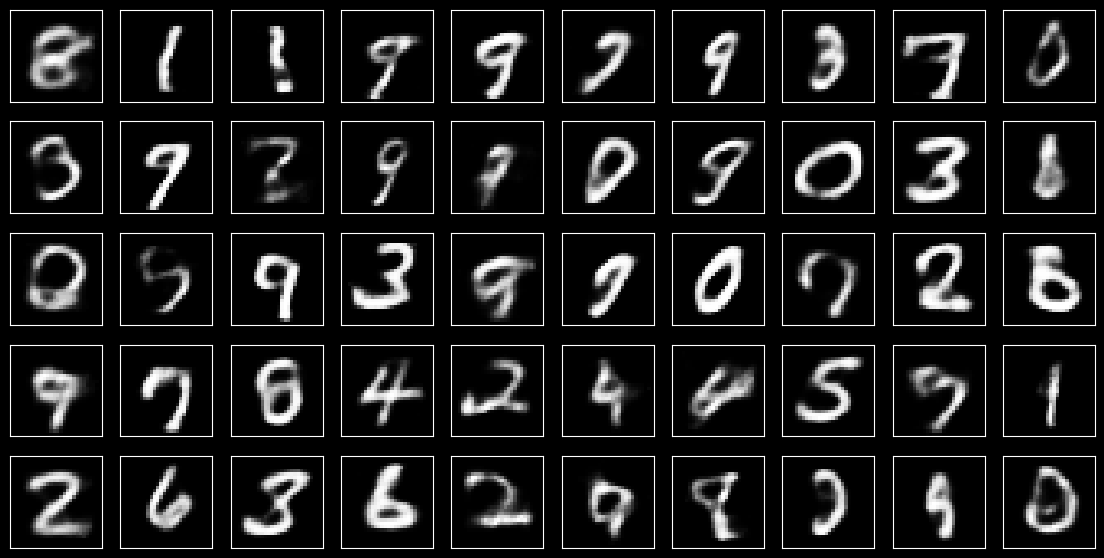

In [ ]:
plot_samples(sample_vae(dec=dec))

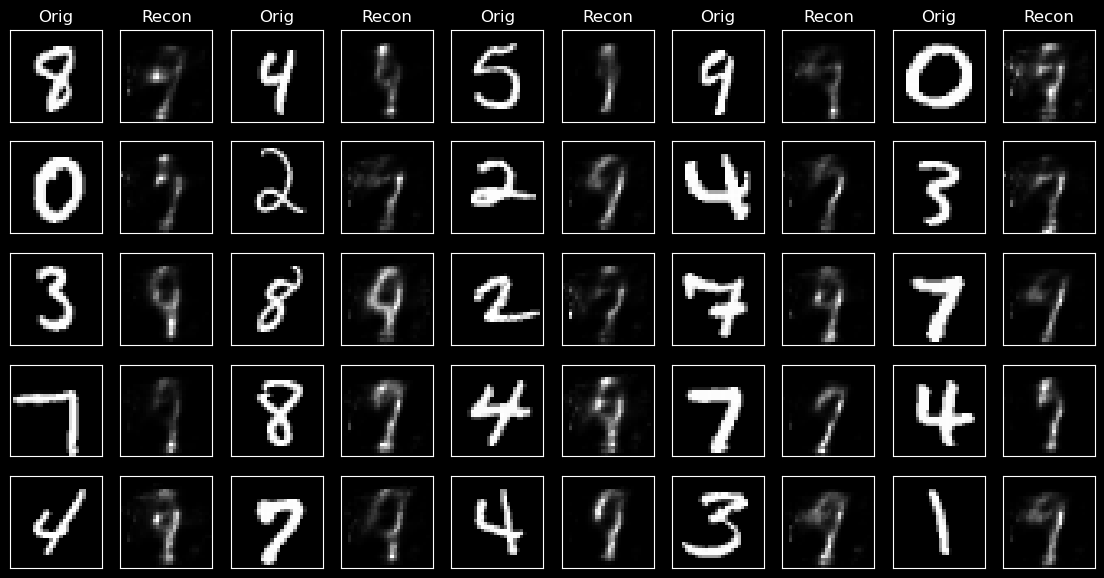

In [ ]:
def plot_reconstructions(loss, model):
    with torch.no_grad():
        batch = torch.stack([test_loader.dataset[i][0] for i in range(25)]).float() / 255.0
        batch = batch.view(-1, D).to(device)
        _, rec = loss(batch, *model)
        rec = torch.sigmoid(rec)
        rec = rec.view(-1, 28, 28).cpu().numpy()
        batch = batch.view(-1, 28, 28).cpu().numpy()

        fig, axes = plt.subplots(
            nrows=5, ncols=10, figsize=(14, 7), subplot_kw={"xticks": [], "yticks": []}
        )
        for i in range(25):
            if i % 5 == 0:
                axes[i % 5, 2 * (i // 5)].set_title("Orig")
                axes[i % 5, 2 * (i // 5) + 1].set_title("Recon")
            axes[i % 5, 2 * (i // 5)].imshow(batch[i], cmap="gray")
            axes[i % 5, 2 * (i // 5) + 1].imshow(rec[i], cmap="gray")


plot_reconstructions(loss_vae, [enc, dec])